In [1]:
!jupyter-nbconvert --to python --template python_clean Block.ipynb

[NbConvertApp] Converting notebook Block.ipynb to python
[NbConvertApp] Writing 27818 bytes to Block.py


In [4]:
# logger = logging.getLogger(__name__)
# logger.root.setLevel('DEBUG')

In [5]:
import logging
import textwrap
from random import randrange
from PIL import Image, ImageDraw, ImageFont, ImageOps
from pathlib import Path

try:
    from . import constants
except ImportError as e:
    import constants

In [6]:
def strict_enforce(*types):
    """strictly enforce type compliance within classes
    
    Usage:
    @strict_enforce(type1, type2, (type3, type4))
    def foo(val1, val2, val4):
        ...
    """
    def decorator(f):
        def new_f(self, *args, **kwds):
            #we need to convert args into something mutable   
            newargs = []        
            for (a, t) in zip(args, types):
                if not isinstance(a, t):
                    raise TypeError(f'"{a}" is not type {t}')
#                 newargs.append( t(a)) #feel free to have more elaborated convertion
            return f(self, *args, **kwds)
        return new_f
    return decorator

In [7]:
def permissive_enforce(*types):
    """decorator to enforce type compliance within classes
    
    Allows similar types:
        for int: 0, 0.1
        for bool: 0, 1, 'some string', False, True
        for string: 7, 66, '77', 'some string', False, True
    
    Usage:
    @permissive_enforce(type1, type2, typeN)
    def foo(self, val1, val2, valN):
        ...
    """
    def decorator(f):
        def new_f(self, *args, **kwds):
            #we need to convert args into something mutable   
            newargs = []        
            for (a, t) in zip(args, types):
                newargs.append( t(a)) #feel free to have more elaborated convertion
            return f(self, *newargs, **kwds)
        return new_f
    return decorator

In [8]:
class BlockError(Exception):
    '''General error class for Blocks'''
    pass
    

In [9]:
class Block:
    def __init__(self, area, hcenter=False, vcenter=False, rand=False, inverse=False,
                abs_coordinates=(0, 0), padding=0, fill=0, bkground=255, mode='1', **kwargs):
        '''Create a Block object
        
        Parent class for other types of blocks
        
        Args [default value]: 
            area(list/tuple): x and y integer values for dimensions of block area
            hcenter(bool): True: horizontally center contents [False]
            vcenter(bool): True: vertically center contents [False]
            rand(bool): True: randomly place contents in area [False]
            inverse(bool): True: invert pixel values [False]
            abs_coordinates(list/tuple): x, y integer coordinates of this block area
                within a larger image 
            padding(int): number of pixels to pad around edge of contents [0]
                this will decrease the usable area to x-2*padding, y-2*padding
            fill(int): 0-255 8 bit value for fill color for text/images [0 (black)]
            bkground(int): 0-255 8 bit value for background color [255 (white)]\
            mode(str): '1': 1 bit color, 'L': 8 bit grayscale ['1']
            
        Properties:
            image: None - overridden in child classes
            padded_area(tuple): area less padding to form padded border around block'''
        self.mode = mode
        self.bkground = bkground
        self.fill = fill
        self.area = area
        self.padding = padding
        self.hcenter = hcenter
        self.vcenter = vcenter
        self.rand = rand
        self.inverse = inverse
        self.abs_coordinates = abs_coordinates
        image = None
        logging.debug('creating Block')
        if self.fill == self.bkground:
            logging.warning('fill and background are identical, this will likely result in no visible image')    

    @property
    def mode(self):
        '''string: PIL image color mode "1": 1 bit, "L": 8 bit'''
        return self._mode
    
    @mode.setter
    @strict_enforce(str)
    def mode(self, mode):
        if mode not in ['1', 'L']:
            raise ValueError(f'invalid mode, valid modes are "1": 1 bit, "L": 8 bit: {mode}')
        self._mode = mode
            
    @property
    def bkground(self):
        '''int: background color: (8 bit) 0-255
        
        Raises:
            ValueError (non positive integer)'''
        return self._bkground
    
    @bkground.setter
    @strict_enforce(int)
    def bkground(self, bkground):
        if  bkground < 0 or bkground > 255:
            raise ValueError(f'bkground must be between 0:255: {bkground}')
        
        # use this as the "original" bkground value
        if not hasattr(self, 'bkground'):
            self._set_bkground = bkground
        
        self._bkground = bkground
    
    @property
    def fill(self):
        '''int: fill color (foreground text, lines, etc.): (8 bit) 0-255
        
        Raises:
            ValueError (non po)'''
        return self._fill
    
    @fill.setter
    @strict_enforce(int)
    def fill(self, fill):
        if fill < 0 or fill > 255:
            raise ValueError(f'fill must be between 0:255 {bkground}')
        # use this as the "original" fill value
        if not hasattr(self, 'fill'):
            self._set_fill = fill    
        self._fill = fill
    
    @property
    def area(self):
        '''tuple/list of int: total area of block: tuple/list of integer
        
        Raises:
            ValueError (non integers)'''
        return self._area
    
    @area.setter
    @strict_enforce((tuple, list))
    def area(self, area):
        if len(area) > 2:
            raise ValueError(f'area should be a list-like object with length 2: {area}')
        
        for i in area:
            if not isinstance(i, int) or i < 1:
                raise ValueError(f'area must be integer values greater than 0: {area}')
                
        self._area = area
        logging.debug(f'block area: {self._area}')
                
    
    @property
    def padding(self):
        '''int: pixels to pad around left, right, top, bottom
        
        Sets:
            padded_area(tuple)
        
        Raises:
            ValueError(non integers)'''
        return self._padding
    
    @padding.setter
    @strict_enforce(int)
    def padding(self, padding):
        if padding < 0:
            raise ValueError(f'padding value must be a positive integer: {padding}')
        
        for i in self.area:
            if padding >= i/2:
                logging.warning(f'padding value is greater >= 1/2 of area dimension {i}, no image will be displayed: {padding}')
        
        self._padding = padding
        self.padded_area = [self.area[0]-2*self.padding, self.area[1]-2*self.padding]
        
        logging.debug(f'padded area: {self.padded_area}')
        if self.padded_area[0] < .25* self.area[0] or self.padded_area[1] < .25*self.area[1]:
            logging.warning(f'the padded area available may be too small to display any content: Area: {self.area}, Padded Area: {self.padded_area}')
    
#     @property
#     def scale(self):
#         return self._scale
    
#     @scale.setter
#     @strict_enforce(bool)
#     def scale(self, scale):
#         self._scale = scale
        
    @property
    def hcenter(self):
        '''bool: horizontally center when true'''
        return self._hcenter
    
    @hcenter.setter
    @strict_enforce(bool)
    def hcenter(self, hcenter):
        self._hcenter = hcenter
        
    @property
    def vcenter(self):
        '''bool: vertically center when true'''
        return self._vcenter
    
    @vcenter.setter
    @strict_enforce(bool)
    def vcenter(self, vcenter):
        self._vcenter = vcenter
        
    @property
    def rand(self):
        '''bool: randomly position when true (overrides hcenter, vcenter)'''
        return self._rand
    
    @rand.setter
    @strict_enforce(bool)
    def rand(self, rand):
        self._rand = rand
        
    @property
    def inverse(self):
        '''bool: swap fill and foreground colors, invert images'''
        return self._inverse
    
    @inverse.setter
    @strict_enforce(bool)
    def inverse(self, inverse):
        if inverse:
            self.fill = self._set_bkground
            self.bkground = self._set_fill
        else:
            self.bkground = self._set_bkground
            self.fill = self._set_fill
            
        logging.debug(f'fill: {self.fill}, bkground: {self.bkground}')
        self._inverse = inverse
    
    @property
    def abs_coordinates(self):
        return self._abs_coordinates
    
    @abs_coordinates.setter
    @strict_enforce((tuple, list))
    def abs_coordinates(self, abs_coordinates):
        if len(abs_coordinates) > 2:
            raise ValueError(f'area should be a list-like object with length 2: {abs_coordinates}')
                
        self._abs_coordinates = abs_coordinates

In [14]:
class TextBlock(Block):
    """Constructor for TextBlock Class
    
    Child class of Block
    
    Individual image block used in assembling composite epdlib.Screen images 
    when writing to a WaveShare ePaper display.
    
    TextBlock objects are aware of their dimensions, absolute coordinates, and 
    contain an 1 bit PIL.Image object of the specified area.
    
    TextBlock objects format strings into multi-line text using wordwrap to 
    fit the maximum number of characters on each line given a particular font.
    
    TextBlock objects will calculate the maximum number of characters that will
    reasonably fit per line based on the font face, font size, area provided and
    the character distribution for a supported language. 
    
    TTF fonts (excluding monotype faces) render each character at a different width.
    The letter i takes less space than the letter W on a line. Each language 
    inherently has a different character distribution. In English, the lower-case
    `e` appears most frequently; Portugese and Turkish use `a` most frequently. 
    This difference in distrubution is subtle, but the aim of this module is to 
    provide the *maximum* number of characters per line.
    
    TextBlock objects use the letter distribution from a selected language (default
    is english) to calculate a random string and then size that string to fit the 
    area. 
    
    Supported languages can be found in the constants.py file.
    
    Format options include scaling, inverting and horizontal/vertical centering and
    random placement of the text within the area.
    
    Overrides:
        image (:obj:`PIL.Image` or str): PIL image object or string path to image file
        upate (method): update contents of ImageBlock"""                    
    def __init__(self, area, font, *args, text="NONE", font_size=0, 
                 chardist=None, max_lines=1, maxchar=None, align='left', **kwargs):
        """Intializes TextBlock object
        
        Args:
            font (str): path to TTF font to use for rendering text
            text (str): string to render
            font_size (int): size of font in points
            max_lines (int): maximum number of lines of text to use 
            maxchar (int, optional): maximum number of characters to render
                per line. If this is not specified, it will be calculated
                using the fontface and a typical character distribution for 
                a given language (see chardist below)
            chardist (str, optional): string matching one of the character 
                distributions in constants.py (default USA_CHARDIST)
        
        Properties:
            text_formatted('str'): text with line breaks according to maxchar and max_lines
            image(PIL:Image): text rendered as an image
            
            """        
        super().__init__(area, *args, **kwargs)
        self.align = align
        self.font_size = font_size
        self.chardist = chardist
        self.maxchar = maxchar
        
        self.font = font
        self.max_lines = max_lines
        self.text = text
    
    @property
    def align(self):
        '''str: text alignment "left", "right" or "center"'''
        return self._align
    
    @align.setter
    def align(self, align):
        if align not in ["left", "right", "center"]:
            raise ValueError('align must be "left", "center" or "right"')
        self._align = align
    
    @property
    def font_size(self):
        '''int: font size in pixels'''
        return self._font_size  
    
    @font_size.setter
    @strict_enforce(int)
    def font_size(self, font_size):
        if font_size < 0:
            raise ValueError(f'font_size must be integer >= 0')
        
        if font_size == 0:
            font_size = int(self.area[0]/40)
            logging.warning('no font size set, using {font_size}')
            
        self._font_size = font_size

    @property
    def font(self):
        """:obj:ImageFont.truetype: Path to TTF font file
        
        If the fontface is changed after initialization, it is recommended to
        recalculate the 
        
        Args:
            font(:obj:`pathlib.Path` or :obj:str)"""
        return self._font
    
    @font.setter
    @strict_enforce((Path, str))
    def font(self, font):   
        old_font = None
        logging.debug(f'setting old_font = {old_font}')
        if hasattr(self, '_font'):
            old_font = self.font
            logging.debug(f'old_font now = {old_font}')

        self._font = ImageFont.truetype(str(Path(font).resolve()), size=self.font_size)
        # trigger a calculation of maxchar if not already set
        if not self.maxchar or (self.font != old_font):
            self.maxchar = self._calc_maxchar()          
        
    @property
    def chardist(self):
        '''`dictionary` character distribution dictionary
        
        see method `print_chardist` for included character distributions'''
        return self._chardist
    
    @chardist.setter
    def chardist(self, chardist):
        if not chardist:
            chardist = "USA_CHARDIST"
            
        self._chardist = getattr(constants, chardist)
        
    @property
    def maxchar(self):
        '''`int`: maximum number of characters to render per line (used for calculating word-wrapping)'''
        return self._maxchar
    
    @maxchar.setter
    def maxchar(self, maxchar):
        if not maxchar:
            maxchar = None
        elif maxchar < 1:
            raise ValueError(f'maxchar must be integer > 0: {maxchar}')
            
            
        self._maxchar = maxchar

    @property
    def max_lines(self):
        """:obj:int maximum number of lines to use when word-wrapping"""
        return self._max_lines
    
    @max_lines.setter
    @strict_enforce(int)
    def max_lines(self, max_lines):
        if max_lines < 1:
            raise ValueError(f'max lines must be integer > 0: {max_lines}')
        self._max_lines = max_lines        
        
    @property
    def text(self):
        """str: text string to format
        
        Sets:
            text_formatted(str): text fomratted with line breaks"""
        return self._text
    
    @text.setter
    @permissive_enforce(str)
    def text(self, text):
        if text:
            self._text = text
        self.text_formatted = self._text_formatter()
        self.image = self._text2image()

    def update(self, update=None):
        """Update image data including coordinates (overrides base class)
        
        Args:
            update (str): text to format and use
            
        Returns:
            :obj:bool - true for successful update"""
        if update:
            try:
                self.text = update
            except Exception as e:
                logging.error(f'failed to update: {e}')
                return False
            return True        

    def _calc_maxchar(self):
        """calculate the maximum number of characters that can fit within the specified area
          using the current font, specified character distribution (`chardist`) 
          and x-dimension of the `area`. This is used to calculate textwrapping.
          
        Returns:
            :obj:int: characters per line"""
        if not self.font:
            raise AttributeError('no font is set - cannot calculate maximum characters per line')
        logging.debug(f'calculating maximum characters for font {self.font.getname()}')
        
        # holder for strings
        s = ''
        # max number of characters to sample from the character distribution
        n = 1000
        # create a random string of characters containing the letter distribution
        for char in self.chardist:
            s = s+(char*int(self.chardist[char]*n))
        s_length = self.font.getsize(s)[0] # string length in Pixles
        # find average width of each character
        avg_width = s_length/len(s)
        logging.debug(f'average character width: {avg_width}')
        maxchar = round(self.padded_area[0]/avg_width)
        self._maxchar = maxchar
        logging.debug(f'maximum characters per line: {maxchar}')
        
        return maxchar        

    def _text_formatter(self):
        """format text using word-wrap strategies. 
        
        Formatting is based on number of lines, area size and maximum characters per line
        
        Args:
            text (str): raw text
            maxchar (int): maximum number of characters on each line
            max_lines (int): maximum number of lines
            
        Returns:
            :obj:`list` of :obj:`str`"""        
        logging.debug(f'formatting string: {self.text}')
#         wrapper = textwrap.TextWrapper(width=self.maxchar, max_lines=self.max_lines, placeholder='…',
#                                       break_long_words=True, )
#         formatted = wrapper.wrap(self.text)
#         logging.debug(f'formatted list:\n {formatted}')
        formatted = textwrap.fill(self.text, 
                                  width=self.maxchar, 
                                  max_lines=self.max_lines, 
                                  placeholder='…')
        return(formatted)
    
    def _text2image(self):
        """Converts text to grayscale image using formatted text
        
        Returns:
            (PIL.Image, tuple of bounding box) """
        
#         # max area for rendering text
#         text_image = Image.new(mode=self.mode, size=self.padded_area, color=self.bkground)
        # scratch image for measuring text 
        scratch_image = Image.new(mode=self.mode, size=(1, 1), color=self.bkground)
        draw = ImageDraw.Draw(scratch_image)
        
        # height offset from top of character to top of bounding box 
        y_offset = draw.textbbox((0, 0), 
                                 text=self.text_formatted, 
                                 font=self.font, 
                                 align=self.align)[1] * -1

        # text_mlbbox[1]*-1 is the total height from assent to decender (anchor with ld -- left decender
        # text_mlbbox[2] is the total x length
        text_mlbbox = draw.multiline_textbbox((0, 0), 
                                              text=self.text_formatted, 
                                              font=self.font, 
                                              align=self.align, 
                                              anchor='ld')
        
        textsize = (text_mlbbox[2], text_mlbbox[1]*-1)
        logging.debug(f'text size: {textsize}')        
        
        
        if textsize[0] > self.padded_area[0] or textsize[1] > self.padded_area[1]:
            logging.info('the text will spill outside of padded area using these values')
        
        # create a new image based on textsize
        text_image = Image.new(mode=self.mode, size=textsize, color=self.bkground)
        draw = ImageDraw.Draw(text_image)
        draw.multiline_text((0, y_offset), 
                                text=self.text_formatted, 
                                font=self.font, 
                                align=self.align,
                                fill=self.fill)        
    
        
        paste_x = self.padding
        paste_y = self.padding
        
        if self.rand:

            x_max = self.padded_area[0] - textsize[0]
            y_max = self.padded_area[1] - textsize[1]
            
            try:
                paste_x = randrange(0, x_max, 1) + self.padding
            except ValueError:
                logging.info('text image is too large for random placement in x dimension')
                x_max = self.padding
            try:
                paste_y = randrange(0, y_max, 1) + self.padding
            except ValueError:
                logging.info('text image is too large for random placement in y dimension')
                y_max = self.padding
                
            logging.debug(f'pasting using random coordinates')
            
        
        if self.hcenter:
            paste_x = int((self.area[0] - textsize[0])/2)
            logging.debug('pasting hcenterd')
            
        if self.vcenter:
            paste_y = int((self.area[1] - textsize[1])/2)
            logging.debug('pasting vcentered')
            
        
        logging.debug(f'paste coordinates: {paste_x, paste_y}')
        final_image = Image.new(mode=self.mode, size=self.area, color=self.bkground)
        final_image.paste(text_image, (paste_x, paste_y))
        
        
        return final_image


    def print_chardist(self, chardist=None):
        """Print supported character distributions
        
            call with no arguments to see available distributions
            
            call with name of character distrubtion to see fractional distribution
        
        Args:
            chardist(:obj:str): string representing listed character distribution """
        if not chardist:
            print('available character distributions:')
            print ([ f'{i}' for i in dir(constants) if not i.startswith("__")])
        else:
            print(f'Character Distribution for {chardist}:')
            char_dict = getattr(constants, chardist)
            
            for i in char_dict:
                print(f'{i}:     {char_dict[i]:.5f}')
        

DEBUG:root:block area: (800, 600)
DEBUG:root:padded area: [680, 480]
DEBUG:root:fill: 0, bkground: 255
DEBUG:root:creating Block
DEBUG:root:setting old_font = None
DEBUG:root:calculating maximum characters for font ('Open Sans', 'Regular')
DEBUG:root:average character width: 31.184024266936298
DEBUG:root:maximum characters per line: 22
DEBUG:root:formatting string: NONE
DEBUG:root:text size: (156, 57)
DEBUG:root:pasting vcentered
DEBUG:root:paste coordinates: (60, 271)
DEBUG:root:formatting string: Lorem ipsum dolor sit amet, consectetur adipiscing elit. QqWYZAXEtiam sed nunc et neque lobortis condimentum. Mauris tortor mi, dictum aliquet sapien auctor, facilisis aliquam metus. Mauris lacinia turpis sit amet ex fringilla aliquet.
DEBUG:root:text size: (650, 437)
DEBUG:root:pasting vcentered
DEBUG:root:paste coordinates: (60, 81)


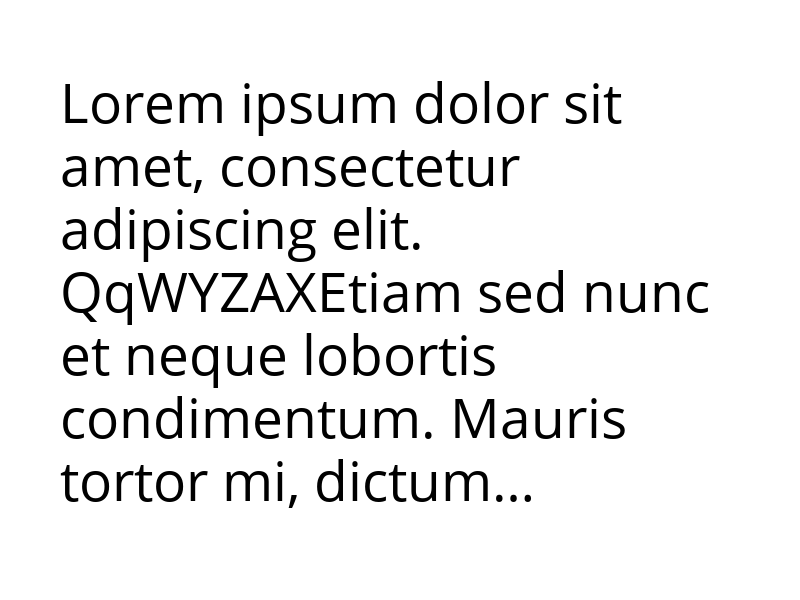

In [20]:
# t = TextBlock(area=(800, 600), font='../fonts/Open_Sans/OpenSans-Regular.ttf', font_size=55, max_lines=7,
#              padding=60, inverse=False, hcenter=False, vcenter=True, rand=False, mode='L', align='left')
# t.text = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit. QqWYZAXEtiam sed nunc et neque lobortis condimentum. Mauris tortor mi, dictum aliquet sapien auctor, facilisis aliquam metus. Mauris lacinia turpis sit amet ex fringilla aliquet.'
# # t.text = 'the quick brown fox jumps over the lazy dog. Pack my boxes with a dozen jugs of liquor.'
# t.update()
# t.image

In [ ]:
class ImageBlock(Block):
    """Constructor for TextBlock Class
    
    Child class of Block
    
    Individual image block used in assembling composite epdlib.Screen images 
    when writing to a WaveShare ePaper display.
    
    ImageBlock objects are aware of their dimensions, absolute coordinates, and 
    contain an 1 bit or 8 bit PIL.Image object of the specified area.
    
    Format options include scaling, inverting and horizontal/vertical centering and
    random placement of the image within the area.
    
    Overrides:
        image (:obj:`PIL.Image` or str): PIL image object or string path to image file
        update (method): update contents of ImageBlock"""    
    def __init__(self, area, *args, image=None, **kwargs):
        '''Initializes ImageBlock
        
        Args:
            area(tuple of int): area of block in x/y
            image(PIL.Image, pathlib.Path or similar): image to place in block'''
        
        super().__init__(area, *args, **kwargs)
        
        
        self.image = image
        
    @property
    def image(self):
        '''PIL.Image: image object with size equal to area of block
        
        Raises:
            BlockError(unusable or missing image file)'''
        
        return self._image
    
    @image.setter
    def image(self, image):

        image_area = Image.new(self.mode, self.area, self.bkground)
    
        if not image or image==True:
            logging.debug(f'no image set; setting to blank image with area: {self.area}')
            self._image = image_area
            return

        if image:
            if isinstance(image, (str, Path)):
                try:
                    im = Image.open(image)

                except (PermissionError, FileNotFoundError, OSError) as e:
                    raise BlockError(f'Could not open file "{image}": {e}')
            elif isinstance(image, Image.Image):
                im = image
            else:
                raise BlockError('unusable image format')

                
            if max(im.size) > max(self.area):
                resize = [self.area[0] - self.padding*2, self.area[1] - self.padding*2]
                im.thumbnail(resize, Image.BICUBIC)
                logging.debug('resizing image to fit in area')
                
            if self.inverse:
                im = ImageOps.invert(im)
            logging.debug(f'padding: {self.padding}')
            paste_x = self.padding
            paste_y = self.padding

            if self.hcenter:
                paste_x = int((self.area[0] - im.width)/2)

            if self.vcenter:
                paste_y = int((self.area[1] - im.height)/2) 

            if self.rand:
                if self.hcenter:
                    logging.info('`rand` overrides hcenter')
                if self.vcenter:
                    logging.info('`rand` overrides vcenter')
                x_range = int(self.area[0] - im.width - self.padding)
                y_range = int(self.area[1] - im.height - self.padding)
                logging.debug(f'x_range: {x_range}, y_range: {y_range}')



                # choose random placement
                try:
                    paste_x = randrange(self.padding, x_range-self.padding, 1)
                except ValueError as e:
                    logging.info('x image dimension is too large for random placement')
                
                try:
                    paste_y = randrange(self.padding, y_range-self.padding, 1)  
                except ValueError as e:
                    logging.info('y image dimension is too large for random placement')

            image_area.paste(im, (paste_x, paste_y))
            
            self._image = image_area
    
    def update(self, update=None):
        """Update image data including coordinates (overrides base class)
        
        Args:
            update(PIL or Path): image to use in update
            
        Returns:
            :obj:bool on success"""        
        if update:
            try:
                self.image = update
            except Exception as e:
                logging.error(f'failed to update due to error: {e}')
                return False
            return True
        else:
            logging.warn('update called with no arguments, no action taken')
            return False        

In [ ]:
# i = ImageBlock(area=(900, 800), mode='L', 
#                hcenter=True, vcenter=True, padding=10, rand=False, inverse=False, bkground=200)
# i.update('../images/portrait-pilot_SW0YN0Z5T0.jpg')
# # i.update('../images/hubble.jpg')

# i.image


In [ ]:
def dir2dict(obj):
    d = {}
    for i in dir(obj):
        d[i] = id(i)
    return d

In [ ]:
def compare_obj(a, b):
    d = []
    for key in a: 
        if key in b:
            if a[key] == b[key]:
                d.append((key, a[key]))
                
    return d

In [ ]:
# logger = logging.getLogger(__name__)
# logger.root.setLevel('DEBUG')